In [2]:
ls ../test-data

EQY_US_ALL_BBO_20140206.h5   new-test.zip                 small_test_data_public.zip
EQY_US_ALL_BBO_20140206.zip  private_test_data.zip
S120114-v50.txt.gz           small_test_data_public.h5


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import tables as tb

In [4]:
import h5py
import dask.dataframe as dd

In [12]:
import blaze

In [13]:
# fname = '../test-data/EQY_US_ALL_BBO_201402/EQY_US_ALL_BBO_20140206.h5'
fname = '../test-data/small_test_data_public.h5'

In [14]:
# by default, this will be read-only
taq_tb = tb.open_file(fname)

In [15]:
rec_counts = {curr._v_pathname: len(curr) 
              for curr in taq_tb.walk_nodes('/', 'Table')}

In [16]:
# What's our biggest table? (in bytes)
max(rec_counts.values()) * 91 / 2 ** 20 # I think it's 91 bytes...

0.0738534927368164

Anyway, under a gigabyte. So, nothing to worry about even if we have 24 cores.

In [17]:
# But what symbol is that?
max_sym = None
max_rows = 0
for sym, rows in rec_counts.items():
    if rows > max_rows:
        max_rows = rows
        max_sym = sym

In [18]:
max_sym, max_rows

('/ZFKOJB/no_suffix', 851)

Interesting... the S&P 500 ETF

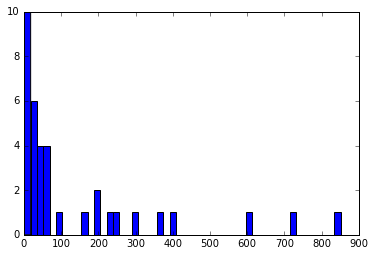

In [20]:
# Most symbols also have way less rows - note this is log xvals
plt.hist(list(rec_counts.values()), bins=50)  #, log=True)
plt.show()

## Doing some compute

We'll use a "big" table to get some sense of timings

In [21]:
spy = taq_tb.get_node(max_sym)

In [22]:
spy[0]['Bid_Price']

17.740199999999998

In [23]:
# PyTables is record oriented...
%timeit np.mean(list(x['Bid_Price'] for x in spy.iterrows()))

100 loops, best of 3: 4.32 ms per loop


In [24]:
np.mean(list(x['Bid_Price'] for x in spy.iterrows()))

18.475936662749703

# Using numexpr?

I am not that smart...

In [47]:
spy_bp = spy.cols.Bid_Price

In [34]:
# not sure this works...
np.mean(spy_bp)

KeyboardInterrupt: 

In [48]:
spy_bp.sum()

AttributeError: 'Column' object has no attribute 'sum'

In [51]:
# But it can use numexpr
expr = tb.Expr('sum(spy_bp)')

In [61]:
%timeit result = expr.eval().mean()

1 loop, best of 3: 3.62 s per loop


In [60]:
tb.Expr('spy_bp').eval().mean()

176.82760773125673

# Dask and h5py?

In [30]:
spy_h5py = h5py.File(fname)[max_sym]

In [34]:
spy_dask = dd.from_array(spy_h5py)
mean_job = spy_dask['Bid_Price'].mean()

In [35]:
%timeit mean_job.compute()

100 loops, best of 3: 6.13 ms per loop


In [36]:
spy_dask = dd.from_array(spy)
mean_job = spy_dask['Bid_Price'].mean()

In [37]:
# Or from pytables?
# This is faster than with h5py, but still slower than pure pytables + numpy!
%timeit mean_job.compute()

100 loops, best of 3: 5.4 ms per loop


# Blaze?

Holy crap!

In [26]:
spy_blaze = blaze.data(spy)

In [28]:
%timeit spy_blaze['Bid_Price'].mean()

10000 loops, best of 3: 111 µs per loop


In [31]:
bpy_blaze = blaze.data(spy_h5py)

In [32]:
%timeit spy_blaze['Bid_Price'].mean()

10000 loops, best of 3: 111 µs per loop


In [34]:
blaze_h5_file = blaze.data(fname)

In [38]:
# This is rather nice
%timeit blaze_h5_file.ZFKOJB.no_suffix.Bid_Price.mean()

The slowest run took 7.40 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.51 µs per loop


In [39]:
blaze_h5_file.ZFKOJB.no_suffix.Bid_Price.mean()

18.475936662749703

# Pandas? 

### To load with Pandas, you need to close the pytables session

In [40]:
taq_tb.close()

In [6]:
# If you want to avoid the pytables above...
max_sym = '/ZFKOJB/no_suffix'

In [7]:
# Pandas has optimizations it likes to do with 
%timeit spy_df = pd.read_hdf(fname, max_sym)

10 loops, best of 3: 32.6 ms per loop


In [9]:
# Actually do it
spy_df = pd.read_hdf(fname, max_sym)

In [10]:
# This is fast, but loading is slow...
%timeit spy_df.Bid_Price.mean()

The slowest run took 6.25 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 57.8 µs per loop
